# CNN architecture for classifying sounds
Convolutional Neural Networks are most commonly used to classify images. However, through data processing sounds can be interpreted as images and be used as such in ML algorithms. This notebook provides an example of this technique on a dataset of common American bird calls.

#### Importing required libraries:

In [211]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import librosa
from glob import glob
import IPython.display as ipd
import tensorflow as tf
from PIL import Image

This is the dataset we are working with. Most of the data can be discarded, as we only need bird's name and the recording of it's call.

In [214]:
df = pd.read_csv("bird-song-data-set/bird_songs_metadata.csv")
df.head(3)

,id,genus,species,subspecies,name,recordist,country,location,latitude,longitude,altitude,sound_type,source_url,license,time,date,remarks,filename
0,557838,Thryomanes,bewickii,NaN,Bewick's Wren,Whitney Neufeld-Kaiser,United States,"Arlington, Snohomish County, Washington",48.0708,-122.1006,100,"adult, sex uncertain, song",//www.xeno-canto.org/557838,//creativecommons.org/licenses/by-nc-sa/4.0/,11:51,2020-03-14,"Recorded with Voice Record Pro on iPhone7, nor...",557838-0.wav
1,557838,Thryomanes,bewickii,NaN,Bewick's Wren,Whitney Neufeld-Kaiser,United States,"Arlington, Snohomish County, Washington",48.0708,-122.1006,100,"adult, sex uncertain, song",//www.xeno-canto.org/557838,//creativecommons.org/licenses/by-nc-sa/4.0/,11:51,2020-03-14,"Recorded with Voice Record Pro on iPhone7, nor...",557838-1.wav
2,557838,Thryomanes,bewickii,NaN,Bewick's Wren,Whitney Neufeld-Kaiser,United States,"Arlington, Snohomish County, Washington",48.0708,-122.1006,100,"adult, sex uncertain, song",//www.xeno-canto.org/557838,//creativecommons.org/licenses/by-nc-sa/4.0/,11:51,2020-03-14,"Recorded with Voice Record Pro on iPhone7, nor...",557838-4.wav


In [216]:
class_names = df["name"].unique()
class_names

array(["Bewick's Wren", 'Northern Mockingbird', 'American Robin',
       'Song Sparrow', 'Northern Cardinal'], dtype=object)

In [218]:
# Compter le nombre de valeurs distinctes dans la colonne "english_cname"
num_distinct_values = df["name"].nunique()

# Afficher le résultat
print(num_distinct_values)


5


In [222]:
df['name'].value_counts()

name
Song Sparrow            1256
Northern Mockingbird    1182
Northern Cardinal       1074
American Robin          1017
Bewick's Wren            893
Name: count, dtype: int64

How many samples for each bird are represented in the dataset.

<BarContainer object of 5 artists>

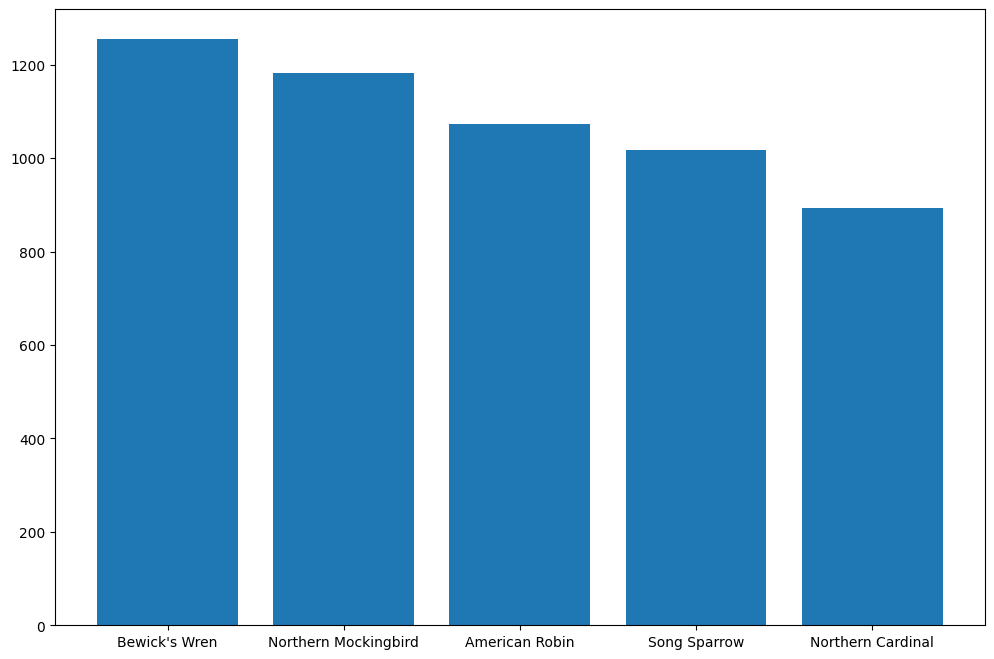

In [225]:
fig, ax = plt.subplots(figsize=(12, 8))
ax.bar(df["name"].unique(), df["name"].value_counts())

In [237]:
df.shape

(5422, 18)

### Mel Spectrogram

Spectrogram is created by sliding a "window" through the data and applying the Fourier transform, splitting the signal into several composing signals and their individual amplitudes. In a spectrogram, X-axis is time, Y-axis is frequency in hertz, and color is loudness. However, humans do not perceive sound on a linear scale, as we can tell the difference between someone whispering (quiet sound) and someone shouting (loud sound) easily, but we have a hard time differentiating between different loud sounds, such as a rocket or a plane taking off. A mel spectrogram represents frequencies on a logarithmic scale. 
Since a spectrogram can be represented by an image, the same CNN architecture for classifying images can be used to classify sounds./kaggle/input/bird-song-data-set/wavfiles

In [233]:
import os
from glob import glob

# Vérification des fichiers audio dans le dossier
audio_files = glob("bird-song-data-set/wavfiles/*.wav")
print(f"Nombre de fichiers audio trouvés : {len(audio_files)}")
print("Exemples de fichiers trouvés :", audio_files[:5])  # Affiche les 5 premiers fichiers



Nombre de fichiers audio trouvés : 9107
Exemples de fichiers trouvés : ['bird-song-data-set/wavfiles\\101308-0.wav', 'bird-song-data-set/wavfiles\\101308-1.wav', 'bird-song-data-set/wavfiles\\101308-10.wav', 'bird-song-data-set/wavfiles\\101308-11.wav', 'bird-song-data-set/wavfiles\\101308-12.wav']


In [245]:
path_to_wav = "bird-song-data-set/wavfiles/"
datafiles = glob(path_to_wav + "*")

In [247]:
def create_mel_spectogram(audio_file, name):
    y, sr = librosa.load(path_to_wav + audio_file)
    mel_spec = librosa.feature.melspectrogram(y=y, sr=sr) 
    mel_spec = librosa.power_to_db(mel_spec, ref=np.max)

    fig, ax = plt.subplots(figsize=(15, 5))

    ax.set_title("Mel Spec")
    plt.suptitle(name)
    librosa.display.specshow(mel_spec, x_axis='time', y_axis='log', ax=ax)
    return ipd.Audio(path_to_wav + audio_file, rate=sr)

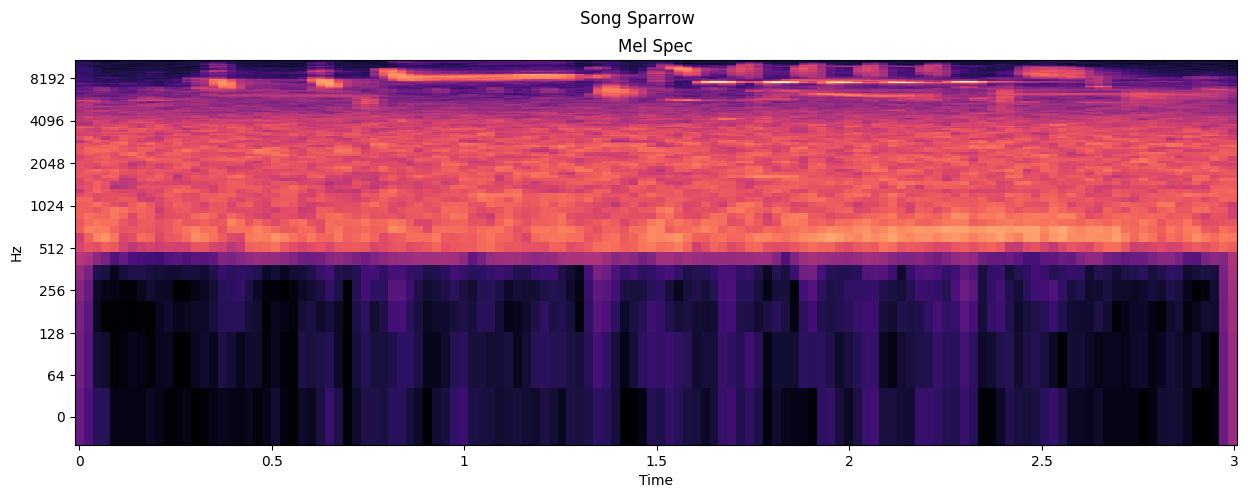

In [249]:
i = np.random.randint(0, df.shape[0])
create_mel_spectogram(df.loc[i, "filename"], df.loc[i, "name"])

In [253]:
def process_audio(audio_file):
    y, sr = librosa.load(audio_file, duration=10)
    mel_spec = librosa.feature.melspectrogram(y=y, sr=sr) 
    mel_spec = librosa.power_to_db(mel_spec, ref=np.max)
    return mel_spec

In [255]:
df_train = pd.DataFrame({"name":df.loc[:, "name"], "audiopath": path_to_wav + df.loc[:, "filename"]})
df_train["mel_spec"] = df_train["audiopath"].apply(process_audio)
df_train["class"] = df_train["name"].factorize()[0]

One-hot encoding class names.

In [257]:
from sklearn.utils import shuffle

df_train = shuffle(df_train)
df_train.shape

(5422, 4)

In [259]:
(train_x, train_y) = df_train["mel_spec"][:5000].values, df_train["class"][:5000].values
(test_x, test_y) = df_train["mel_spec"][5000:].values, df_train["class"][5000:].values

In [261]:
from keras.utils import to_categorical

test_y = to_categorical(test_y, num_classes=5)
train_y = to_categorical(train_y, num_classes=5)

In [269]:
train_x = np.stack(train_x[:])
test_x = np.stack(test_x[:])

train_x = tf.keras.utils.normalize(train_x)
test_x = tf.keras.utils.normalize(test_x)

train_dataset = tf.data.Dataset.from_tensor_slices((train_x, train_y))
test_dataset = tf.data.Dataset.from_tensor_slices((test_x, test_y))


In [271]:
train_dataset = train_dataset.batch(8)
test_dataset = test_dataset.batch(8)
train_dataset = train_dataset.prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.prefetch(tf.data.AUTOTUNE)

In [273]:
import keras
from keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense, Activation, BatchNormalization, Reshape, InputLayer, TimeDistributed, Conv1D, MaxPooling1D, LSTM
from keras.models import Sequential
from keras.regularizers import l2

In [279]:
from keras.models import Sequential
from keras.layers import Input, Conv2D, Dropout, BatchNormalization, MaxPooling2D, Flatten, Dense, Activation
from keras.regularizers import l2

def create_model():
    model = Sequential(name="model")

    # Use Input layer for shape definition
    model.add(Input(shape=(128, 130)))

    # Reshape the input
    model.add(Reshape((128, 130, 1)))
    
    # First set of Conv2D layers
    model.add(Conv2D(64, (8, 8), activation='relu', padding='same'))
    model.add(Conv2D(64, (6, 6), activation='relu', padding='same'))
    model.add(Dropout(0.2))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2)))

    # Second set of Conv2D layers
    model.add(Conv2D(128, (5, 5), activation='relu', padding='same'))
    model.add(Conv2D(128, (5, 5), activation='relu', padding='same'))
    model.add(Dropout(0.2))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2)))

    # Third set of Conv2D layers
    model.add(Conv2D(256, (3, 3), activation='relu', padding='same'))
    model.add(Conv2D(256, (3, 3), activation='relu', padding='same'))
    model.add(Dropout(0.2))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2)))

    # Flatten and Dense layers
    model.add(Flatten())
    model.add(Dense(128, kernel_regularizer=l2(0.01)))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(Dropout(0.2))
    model.add(Dense(5))
    model.add(Activation('softmax'))

    return model

# Create and summarize the model
model = create_model()
model.summary()


Model: "model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ reshape_1 (Reshape)                  │ (None, 128, 130, 1)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_63 (Conv2D)                   │ (None, 128, 130, 64)        │           4,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_64 (Conv2D)                   │ (None, 128, 130, 64)        │         147,520 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_89 (Dropout)                 │ (None, 128, 130, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_47               │ (None, 128, 130, 64)        │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_30 (MaxPooling2D)      │ (None, 64, 65, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_65 (Conv2D)                   │ (None, 64, 65, 128)         │         204,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_66 (Conv2D)                   │ (None, 64, 65, 128)         │         409,728 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_90 (Dropout)                 │ (None, 64, 65, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_48               │ (None, 64, 65, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_31 (MaxPooling2D)      │ (None, 32, 32, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_67 (Conv2D)                   │ (None, 32, 32, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_68 (Conv2D)                   │ (None, 32, 32, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_91 (Dropout)                 │ (None, 32, 32, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_49               │ (None, 32, 32, 256)         │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_32 (MaxPooling2D)      │ (None, 16, 16, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_10 (Flatten)                 │ (None, 65536)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_64 (Dense)                     │ (None, 128)                 │       8,388,736 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_50               │ (None, 128)                 │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 10,043,269 (38.31 MB)

 Trainable params: 10,042,117 (38.31 MB)

 Non-trainable params: 1,152 (4.50 KB)

In [283]:
checkpoint_cb = tf.keras.callbacks.ModelCheckpoint("model.keras", save_best_only=True)

from keras.optimizers import Adam
from keras.losses import CategoricalCrossentropy

model.compile(loss=CategoricalCrossentropy(), optimizer=Adam(learning_rate=0.01), metrics=['accuracy']) ##lr=0.01 decay=1e-6)

In [ ]:
model.fit(train_dataset, epochs=200, validation_data=test_dataset, callbacks=[checkpoint_cb])

Epoch 1/200
273/625 ━━━━━━━━━━━━━━━━━━━━ 7:27 1s/step - accuracy: 0.3968 - loss: 20.7459

In [ ]:
model.evaluate(test_dataset)

In [ ]:
pred_y = model.predict(test_x).argmax(axis=1, keepdims=True)
true_y = test_y.argmax(axis=1, keepdims=True)

In [ ]:
import sklearn.metrics

confusion_matrix = sklearn.metrics.confusion_matrix(true_y, pred_y)
confusion_matrix_display = sklearn.metrics.ConfusionMatrixDisplay(confusion_matrix, display_labels=class_names)
fig, ax = plt.subplots(1, figsize=(8, 8))
confusion_matrix_display.plot(ax=ax, xticks_rotation=10)